In [1]:
!pip install lxml seaborn ipympl


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import requests
import lxml.html

In [29]:
from detoxify import Detoxify
import pandas as pd
from typing import Optional

def make_request(url: str, xpath: str) -> list[str]:
    r = requests.get(url)
    tree = lxml.html.fromstring(r.text)
    titles_list = ["".join(x.itertext()).strip(" \t\n\r|.") for x in tree.xpath(xpath)]
    return sorted(set(titles_list), key=lambda x: titles_list.index(x))

def classify(titles: list[str], model: str = 'multilingual', source: Optional[str] = None):
    results = Detoxify(model).predict(titles)
    df = pd.DataFrame(results).assign(text=titles)
    if source is not None:
        return df.assign(source=source)
    return df
    # return (
    #     results,
    #     {k: (min(v), max(v), np.mean(v)) for k, v in results.items()}
    # )

In [61]:
bbc_titles = make_request("https://bbc.com", "//h3[@class='media__title']")
bbc_summaries = make_request("https://bbc.com", "//p[@class='media__summary']")
breit_titles = make_request("https://www.breitbart.com/", "//article/h2/a")
fox_titles = make_request("https://www.foxnews.com/", "//*[@class='title']/a")
wt_titles = make_request("https://www.washingtontimes.com/", "//h2[@class='article-headline']/a")
nmax_titles = make_request("https://www.newsmax.com/", "//div[@id='nmCanvas1Headline']//h1 | //div[@id='nmLeadStoryContent']/div[@id='nmleadStoryHead']/h2/a | //div[@class='nmNewsfrontT ' or @class='nmleadStoryHead']//h2/a")

In [62]:
bbc_titles_c = classify(bbc_titles, source="bbc_titles")
bbc_summaries_c = classify(bbc_summaries, source="bbc_summaaries")
breit_titles_c = classify(breit_titles, source="breit_titles")
fox_titles_c = classify(fox_titles, source="fox_titles")
wt_titles_c = classify(wt_titles, source="wt_titles")
nmax_titles_c = classify(nmax_titles, source="nmax_titles")

In [63]:
import pandas as pd

df = pd.concat((
    bbc_titles_c,
    bbc_summaries_c,
    breit_titles_c,
    fox_titles_c,
    wt_titles_c,
    nmax_titles_c,
))
melted_df = df.melt(id_vars=['source', 'text'], var_name='category', value_name='score')
melted_df.sample(5)

,source,text,category,score
90,fox_titles,Dave McCormick’s new book could serve as a ‘ba...,toxicity,0.000541
1179,nmax_titles,US Lacks 'Urgency' as China Readies for War,identity_attack,0.000370
162,fox_titles,Faith & Values,toxicity,0.000310
1276,fox_titles,Patriot remembered: Military mom memorializes ...,insult,0.000156
1324,fox_titles,Savings window opens: Today's 30-year mortgage...,insult,0.000684


In [64]:
melted_df[melted_df.category == 'identity_attack'].sort_values('score', ascending=False)

,source,text,category,score
1133,nmax_titles,US Must Treat Mexican Cartels Like 'Terrorists',identity_attack,0.789663
1151,nmax_titles,Transgender Teens Disproportionately Autistic,identity_attack,0.592416
1166,nmax_titles,Suspected Islamist Militants Kill 19 in Congo,identity_attack,0.316971
972,fox_titles,Video of White college student goes viral afte...,identity_attack,0.054007
1104,wt_titles,Schools say American kids are hungry and it’s ...,identity_attack,0.047895
...,...,...,...,...
901,bbc_titles,The young workers in a post-Me Too era,identity_attack,0.000080
1139,nmax_titles,'Robot Lawyer' Sued for Practicing Without Lic...,identity_attack,0.000080
1052,fox_titles,"Sammy Smith, 18-year-old high schooler, picks ...",identity_attack,0.000076
1093,wt_titles,WATCH: Biden proposes a major tax increase. ‘T...,identity_attack,0.000074


In [65]:
melted_df.source.value_counts()

fox_titles        875
nmax_titles       357
bbc_titles        329
wt_titles         315
bbc_summaaries    133
breit_titles       56
Name: source, dtype: int64

/home/daniel/.local/share/hatch/env/virtual/toxic-news/SK7IXFsm/explore/lib/python3.9/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


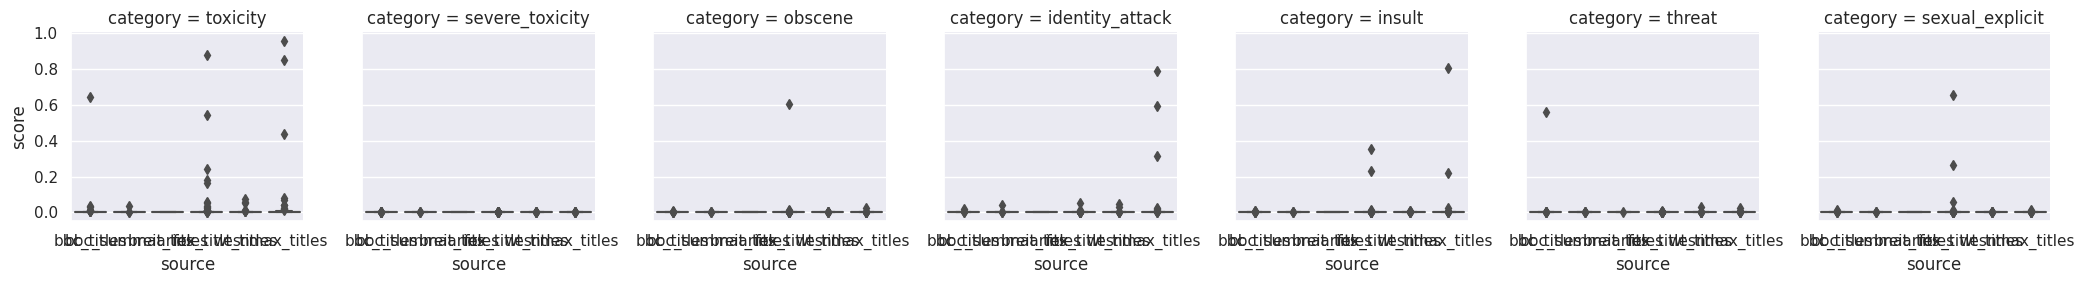

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

def p(x, **kwargs):
    print(x)
    sns.catplot(x, kind='strip', x='source', y='score', **kwargs)

sns.set_theme()
g = sns.FacetGrid(melted_df, col="category")
# g.map(sns.catplot, kind='strip', x='source', y='score', s=3)
g.map(sns.boxplot, 'source', 'score')#, kind='strip')
# g.map(p, 'source', s=3)
# plt.yscale('log')
# sns.stripplot(data=df, x='source', y='toxicity')


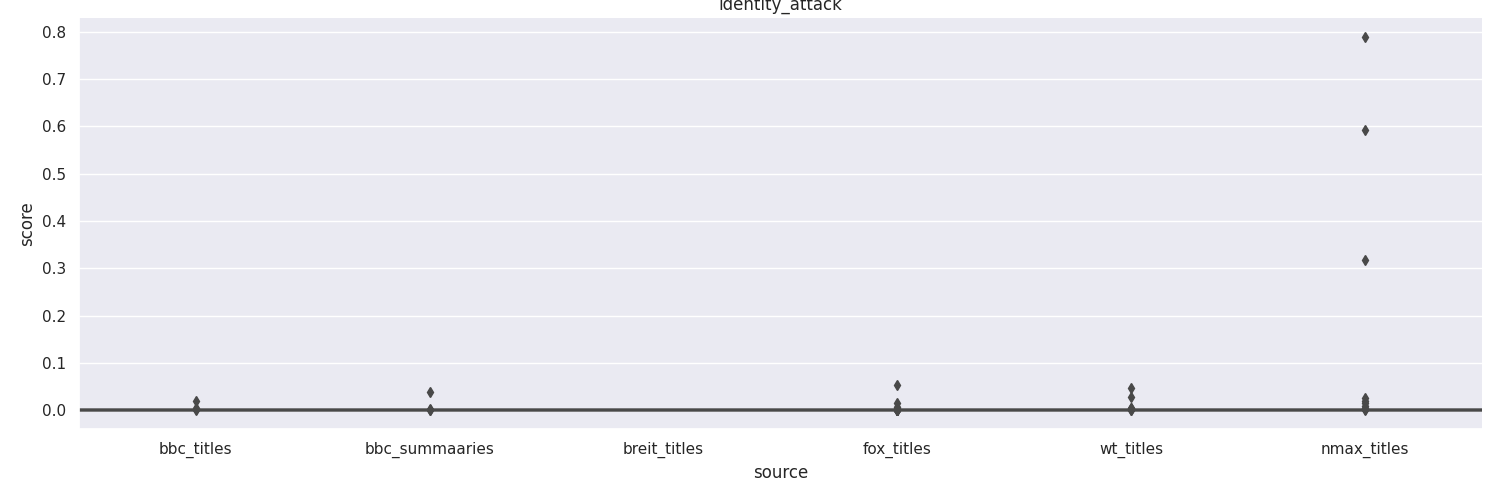

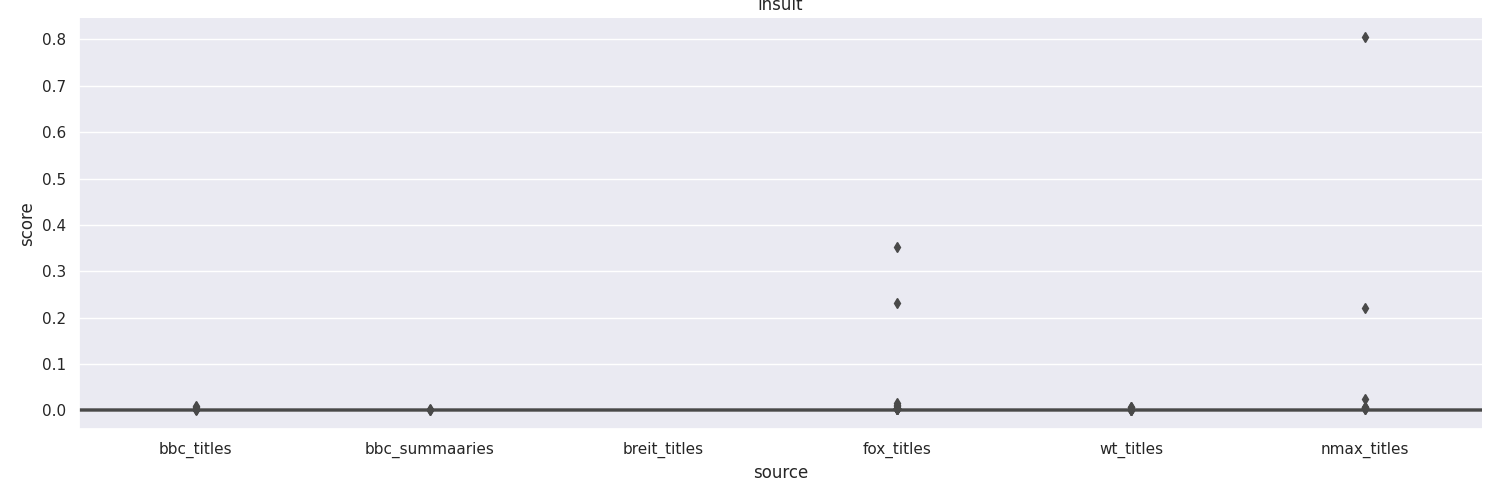

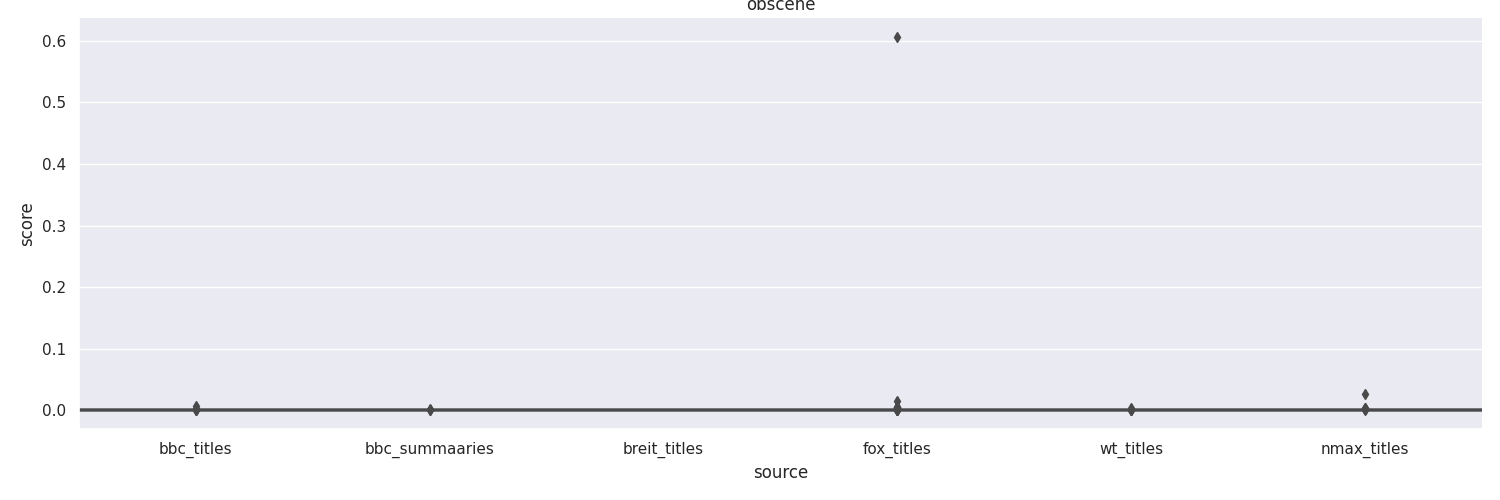

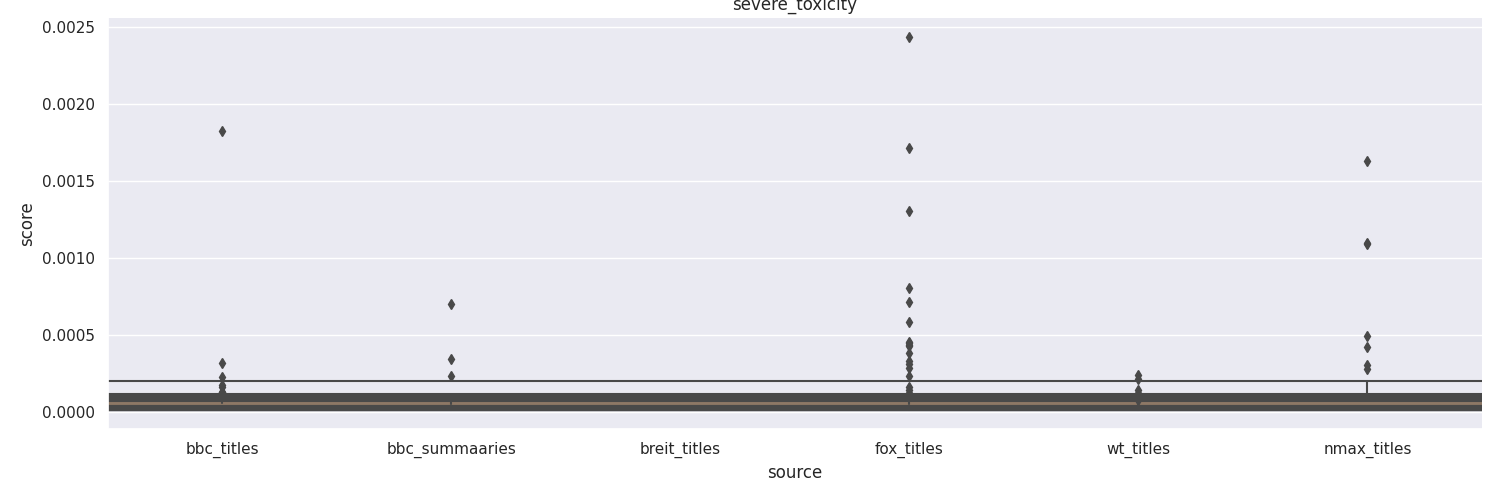

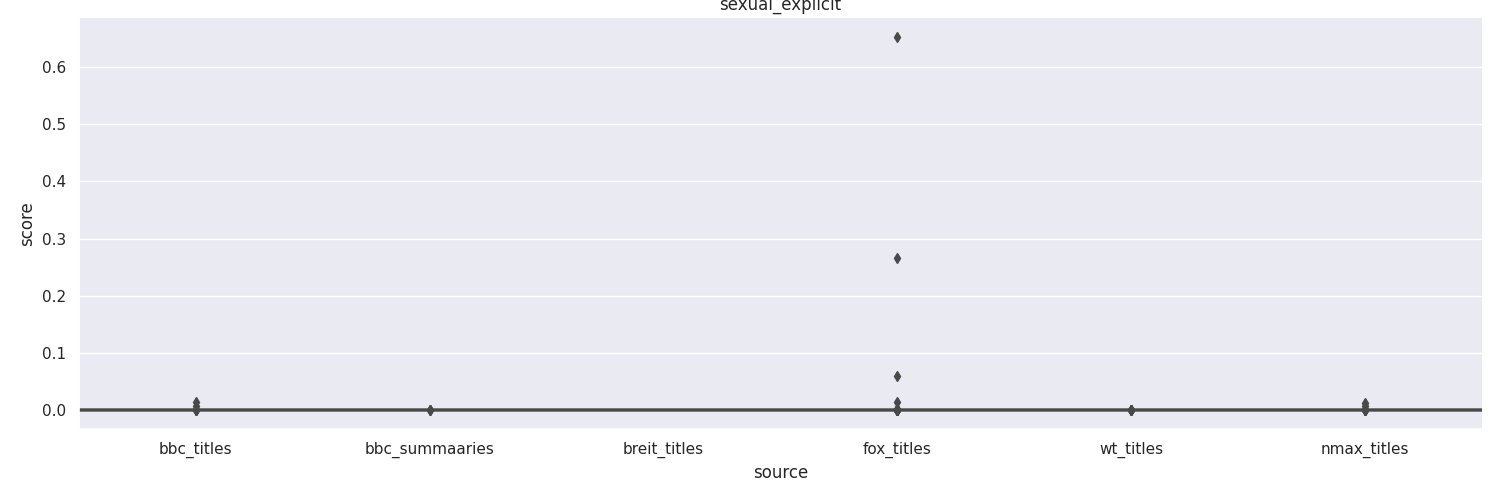

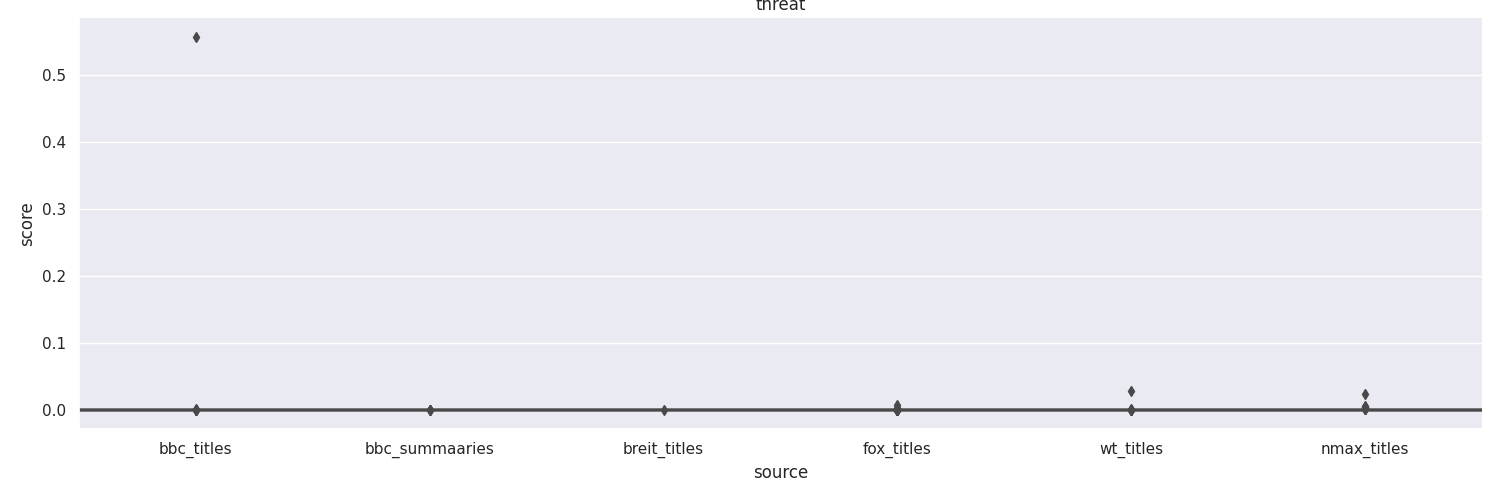

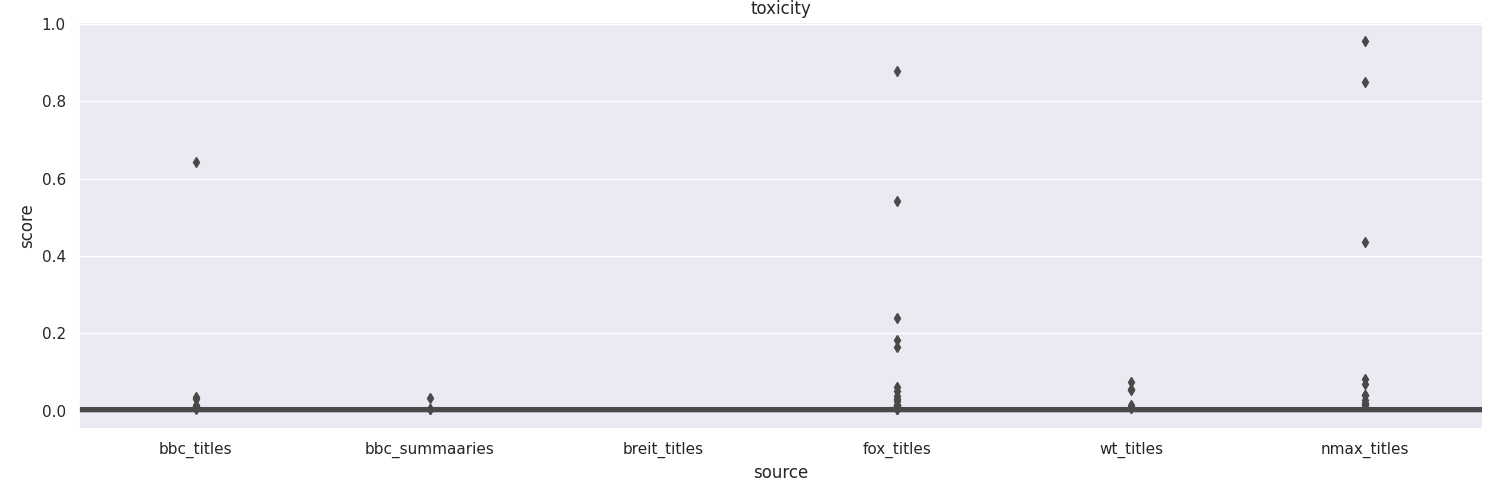

In [68]:
%matplotlib ipympl
# plt.rcParams['figure.figsize'] = map(lambda x: 4*x,[2, 2])
# sns.set(rc={"figure.figsize":(3, 4)})
for c in sorted(melted_df.category.unique()):
    g = sns.catplot(data=melted_df[melted_df.category==c], x='source', y='score', kind='box', width=100, aspect=3)
    g.set(title=c)


In [10]:
pprint.pprint(classify(bbc_titles)[1])

{'identity_attack': (6.937534635653719e-05,
                     0.021666206419467926,
                     0.002098200413622015),
 'insult': (0.00014504289720207453, 0.056654296815395355, 0.004147017672287554),
 'obscene': (0.00010284553718520328,
             0.02794368751347065,
             0.0020675434999165273),
 'severe_toxicity': (1.6580115698161535e-05,
                     0.0053773787803947926,
                     0.00020951070167608452),
 'sexual_explicit': (1.9827466530841775e-05,
                     0.023524608463048935,
                     0.0007953970011426877),
 'threat': (2.926327579189092e-05, 0.025217346847057343, 0.001459275630168122),
 'toxicity': (0.00028490531258285046,
              0.17484082281589508,
              0.016383954502419907)}


In [49]:
pprint.pprint(classify(bbc_summaries)[1])

{'identity_attack': (8.853866893332452e-05,
                     0.00477689690887928,
                     0.0007073406850395259),
 'insult': (0.000233520710025914, 0.03765008598566055, 0.0033779802097342326),
 'obscene': (9.933215915225446e-05,
             0.0017050186870619655,
             0.00046989478050818434),
 'severe_toxicity': (1.304685793002136e-05,
                     0.0003669493307825178,
                     5.9711068274737045e-05),
 'sexual_explicit': (1.914999847940635e-05,
                     0.0065353261306881905,
                     0.0004977739448577267),
 'threat': (2.376504198764451e-05, 0.009634667076170444, 0.0008228220083310589),
 'toxicity': (0.0003358380345162004, 0.07066132873296738, 0.00997237121737271)}


In [50]:
pprint.pprint(classify(breit_titles)[1])

{'identity_attack': (0.00010584529809420928,
                     0.05532475933432579,
                     0.00740655862409767),
 'insult': (0.000190342529094778, 0.03246009722352028, 0.00546598300752521),
 'obscene': (0.0001038434129441157,
             0.0005332885775715113,
             0.0003273978363722563),
 'severe_toxicity': (1.9779779904638417e-05,
                     0.00011905866267625242,
                     5.312734060680668e-05),
 'sexual_explicit': (1.8898257621913217e-05,
                     0.00035412528086453676,
                     0.00011974255676250323),
 'threat': (3.327309605083428e-05,
            0.0004612488846760243,
            0.0001252725228368945),
 'toxicity': (0.00045812592725269496,
              0.12806251645088196,
              0.024108798323140945)}


In [51]:
pprint.pprint(classify(fox_titles)[1])

{'identity_attack': (6.665827095275745e-05,
                     0.038473404943943024,
                     0.0012312731318940807),
 'insult': (0.00012231797154527158, 0.4953838288784027, 0.008050393705967248),
 'obscene': (8.664337656227872e-05, 0.00850195623934269, 0.0005346892244103531),
 'severe_toxicity': (1.2792596862709615e-05,
                     0.0013050440466031432,
                     8.395141096246204e-05),
 'sexual_explicit': (1.626560333534144e-05,
                     0.18553856015205383,
                     0.0027592147132963875),
 'threat': (2.2185866328072734e-05,
            0.0027226239908486605,
            0.00017207576641210055),
 'toxicity': (0.00021347538859117776, 0.531258761882782, 0.01307361361749437)}


({'toxicity': [0.6736449599266052],
  'severe_toxicity': [0.0008609896758571267],
  'obscene': [0.0023542428389191628],
  'identity_attack': [0.7295146584510803],
  'insult': [0.06373408436775208],
  'threat': [0.00469912588596344],
  'sexual_explicit': [0.0015378365060314536]},
 {'toxicity': (0.6736449599266052, 0.6736449599266052, 0.6736449599266052),
  'severe_toxicity': (0.0008609896758571267,
   0.0008609896758571267,
   0.0008609896758571267),
  'obscene': (0.0023542428389191628,
   0.0023542428389191628,
   0.0023542428389191628),
  'identity_attack': (0.7295146584510803,
   0.7295146584510803,
   0.7295146584510803),
  'insult': (0.06373408436775208, 0.06373408436775208, 0.06373408436775208),
  'threat': (0.00469912588596344, 0.00469912588596344, 0.00469912588596344),
  'sexual_explicit': (0.0015378365060314536,
   0.0015378365060314536,
   0.0015378365060314536)})